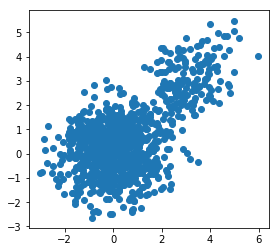

5 steps' pi: 0.6325699033851372
10 steps' pi: 0.680659709224654
15 steps' pi: 0.7173990161939597
20 steps' pi: 0.7506155862592983
25 steps' pi: 0.78062875015863
30 steps' pi: 0.8027172103336846
35 steps' pi: 0.8139455810495141
40 steps' pi: 0.817881579383211
45 steps' pi: 0.818997275365119
50 steps' pi: 0.8192900466492904
55 steps' pi: 0.8193651914399003
60 steps' pi: 0.8193843665346362
权重值： 0.8193880364000932
第一个分模型的均值：
 [[0.038989   0.06512731]]
第一个分模型的协方差矩阵：
 [[1.0459179  0.02543648]
 [0.02543648 0.94394195]]
第二个分模型的均值：
 [[3.00952231 2.95690914]]
第二个分模型的协方差矩阵：
 [[0.89479322 0.42484588]
 [0.42484588 0.97664816]]


In [26]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
 
 
N = 1000
pi = 0.8
mean_1 = np.array([0.0, 0.0])
cov_1 = np.mat([[1.0, 0.0], [0.0, 1.0]])
mean_2 = np.array([3.0, 3.0])
cov_2 = np.mat([[1.0, 0.5], [0.5, 1.0]])
 
 
class GMM:
    def __init__(self, N, pi, mean_1, cov_1, mean_2, cov_2):
        # 采样点数
        self.N = N
        # 高斯分布的权重
        self.pi = pi
        # 第一个二维高斯分布的均值
        self.mean_1 = mean_1
        # 第一个二维高斯分布的协方差矩阵
        self.cov_1 = cov_1
        # 第二个二维高斯分布的均值
        self.mean_2 = mean_2
        # 第二个二维高斯分布的协方差矩阵
        self.cov_2 = cov_2
    
    # 生成观测数据集
    def dataset(self):
        # 数据集大小为(N,2)
        D = np.zeros(shape=(self.N, 2))
        
        for i in range(self.N):
            # 产生0-1之间的随机数
            j = np.random.random()
            if j < self.pi:
                # pi的概率以第一个二维高斯分布产生一个样本点
                x = np.random.multivariate_normal(mean=self.mean_1, cov=self.cov_1, size=1)
            else:
                # 1-pi的概率以第二个二维高斯分布产生一个样本点
                x = np.random.multivariate_normal(mean=self.mean_2, cov=self.cov_2, size=1)
            D[i] = x
        return D


    #高斯混合模型参数初始化
    def EM(self, D, N):
        p = 0.5
        m_1 = np.array([[0.0, 0.0]])
        c_1 = np.mat([[1.0, 0.0], [0.0, 1.0]])
        m_2 = np.array([[1.0, 1.0]])
        c_2 = np.mat([[1.0, 0.0], [0.0, 1.0]])
        return p,m_1,c_1,m_2,c_2
    
    
    # 高斯分布密度phi
    def phi(self,x, mean, cov):
        return np.exp(-(x - mean) * np.linalg.inv(cov) * (x - mean).T / 2) /(2 * np.pi * np.sqrt(np.linalg.det(cov)))

                 
    #E步
    # 分模型对观测数据的响应度gamma（即隐藏变量）
    def gamma(self,D, j, k, p, m_1, c_1, m_2, c_2):   #k为高斯模型个数
        # 第一个分模型
        if k == 0:
            return p * self.phi(D[j], m_1, c_1) / (p * self.phi(D[j], m_1, c_1) + (1 - p) * self.phi(D[j], m_2, c_2))
        # 第二个分模型
        elif k == 1:
            return (1 - p) * self.phi(D[j], m_2, c_2) / (p * self.phi(D[j], m_1, c_1) + (1 - p) * self.phi(D[j], m_2, c_2))
    

    #M步
    #模型的均值mu
    def mu(self,D, g, N):
        # 第一个分模型的均值的分子部分
        mu_1a = np.array([[0.0, 0.0]])
        # 第一个分模型的均值的分母部分
        mu_1b = np.array([[0.0, 0.0]])
        # 第二个分模型的均值的分子部分
        mu_2a = np.array([[0.0, 0.0]])
        # 第二个分模型的均值的分母部分
        mu_2b = np.array([[0.0, 0.0]])
        for j in range(N):
            mu_1a += g[j][0] * D[j]
            mu_1b += g[j][0]
            mu_2a += g[j][1] * D[j]
            mu_2b += g[j][1]
        # 返回第一个分模型的均值和第二个分模型的均值，都是一行两列的矩阵
        return mu_1a / mu_1b, mu_2a / mu_2b


    #模型的协方差矩阵sigma
    def sigma(self,D, m1, m2, g, N):
        # 第一个分模型的协方差矩阵的分子部分
        sigma_1a = np.mat([[0.0, 0.0], [0.0, 0.0]])
        # 第一个分模型的协方差矩阵的分母部分
        sigma_1b = np.mat([[0.0, 0.0], [0.0, 0.0]])
        # 第二个分模型的协方差矩阵的分子部分
        sigma_2a = np.mat([[0.0, 0.0], [0.0, 0.0]])
        # 第二个分模型的协方差矩阵的分母部分
        sigma_2b = np.mat([[0.0, 0.0], [0.0, 0.0]])
        for j in range(N):
            sigma_1a += g[j][0] * ((D[j] - m1).T * (D[j] - m1))
            sigma_1b += g[j][0]
            sigma_2a += g[j][1] * ((D[j] - m2).T * (D[j] - m2))
            sigma_2b += g[j][1]
        # 返回第一个分模型的协方差矩阵和第二个分模型的协方差矩阵，都是两行两列的矩阵
        return sigma_1a / sigma_1b, sigma_2a / sigma_2b
    
    # 模型的权重alpha
    def alpha(self,g, N):
        a = 0
        for j in range(N):
            # 只需要求第一个分模型的权重
            a += g[j][0]
        return a / N


#观测数据集可视化
gmm = GMM(N, pi, mean_1, cov_1, mean_2, cov_2)
plt.figure()
plt.gca().set_aspect('equal')  # 令x轴和y轴的同一区间的刻度相同
D = gmm.dataset()
plt.scatter(D[:, 0], D[:, 1])
plt.show()


#迭代过程
# 权重pi的变化量初始化为1
delta_p = 1

# 迭代次数i
i = 0

p, m_1, c_1, m_2, c_2 = gmm.EM(D, N)
    
# 当权重pi的变化量小于10e-7时停止迭代
while delta_p > 10e-7:
    Gamma = np.zeros(shape=(N, 2))
    for j in range(N):
        for k in range(2):
            # 计算分模型k对观测数据的响应度gamma
            Gamma[j][k] = gmm.gamma(D, j, k, p, m_1, c_1, m_2, c_2)
            
    # 更新模型的均值
    m_1, m_2 = gmm.mu(D, Gamma, N)
        
    # 更新模型的协方差矩阵
    c_1, c_2 = gmm.sigma(D, m_1, m_2, Gamma, N)
        
    # 计算权重pi的变化量
    delta_p = abs(p - gmm.alpha(Gamma, N))
        
    # 更新模型的权重
    p = gmm.alpha(Gamma, N)
 
    i += 1
    # 每五次迭代打印权重值
    if i % 5 == 0:
        print(i, "steps' pi:", p)
        
    
# 返回EM算法学习到的五个参数
print( "权重值：", p) 
print("第一个分模型的均值：\n", m_1)
print("第一个分模型的协方差矩阵：\n", c_1)
print("第二个分模型的均值：\n", m_2)
print("第二个分模型的协方差矩阵：\n",  c_2)

    
    




